In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
import datetime

In [9]:
# Helper to plot loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_acc(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

# Keras Tuner

We can use the Keras Tuner to find the best hyperparameters for our model, in a similar way to how we usd a grid search to find the best hyperparameters for our scikit-learn models. The process is a little more involved, but it's still pretty straightforward. 

### Logs and Records

All of the stuff we are looking at here relies on log and record files being saved to disk. We can save them anywhere, but it is probably a good idea to consolidate them in some organized way. We can do this by creating a new directory called `logs` in the root of our project, and putting the log results in there. One thing to watch out for is that you can sometimes get odd errors or warnings if you are looking at the log files for some other model. This is because it is expecting to find things that it has written for the model to which it belongs. This is very annoying, ask me how I know. For real applications, youd probably want to make specific folders to track these things - for our repeated trials, I have added a little datetime stamp to some file names to just ensure that they are unique.

In [10]:
### Parameters


# Set Base Parameters
# Increase processing demands if on Colab
BASE_EPOCHS = 3
BATCH_SIZE = 256
BASE_PATIENCE = 5
MIN_DELTA = .02
MONITOR = "val_accuracy"
LOGS = "logs"
DIR_OUT = "kt_out"
PROJECT = "kt_basics"
FACTOR = 3
VALIDATION = .2

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  BASE_EPOCHS = 15
  BATCH_SIZE = 64
  BASE_PATIENCE = 10

# Metrics
acc = keras.metrics.CategoricalAccuracy(name="accuracy")
pre = keras.metrics.Precision(name="precision")
rec = keras.metrics.Recall(name="recall")
metric_list = [acc, pre, rec]

# Callbacks
file_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOGS+"/"+file_time, histogram_freq=1, write_images=True, embeddings_freq=1)

#### Load Data

We will start with using the fashion dataset. 

In [11]:
# Load Data
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

## Model Builder

To use Keras Tuner, you need to define a model builder function. This function takes a hyperparameter dictionary as input and returns a compiled model. In plain language, the model builder function is basically a framework for creating a model, with the key difference that we set things up so that the hyperparameters that we are testing are variables in the model construction. 

### HP.whatever

The hyperparameters that we are testing are defined using the HP.[Type_of_choice] functions. For example, HP.Choice defines a hyperparameter that can take on one of a list of values. HP.Float defines a hyperparameter that can take on any value between a minimum and maximum value. HP.Int defines a hyperparameter that can take on any integer value between a minimum and maximum value. Each thing that we want to change in the search is set up with one of these "hp." functions, along with the range of values we want to test.

When the hyperparameter search is called, these hyperparameters will be varied according to the search algorithm that we choose - just as a grid search would work through the various combinations of hyperparameters in the list we supply. We can build this model builder function to test almost anything we can think of - different number of neurons, different number of layers, different types of layers, different activation functions, different optimizers, different learning rates, etc... The possibilities of what we can test are really only limited by our imagination and the time it takes to run the search. Some key hp items to be aware of are:
<ul>
<li>HP.Choice - a hyperparameter that can take on one of a list of values</li>
<li>HP.Float - a hyperparameter that can take on any value between a minimum and maximum value</li>
<li>HP.Int - a hyperparameter that can take on any integer value between a minimum and maximum value</li>
</ul>

In [12]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))

  # Tune whether to use dropout.
  #if hp.Boolean("dropout"):
  #  model.add(layers.Dropout(rate=0.25))

  # Add another layer
  #hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  #model.add(keras.layers.Dense(units=hp_units2, activation='relu'))

  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                loss="categorical_crossentropy",
                metrics=metric_list)

  return model

In [13]:
def model_builder2(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  # Layer 2
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units2, activation='relu'))
  
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

## Hypertuning

Our model builder is the core of the hyperparameter tuning process, using it is relatively simple. We use the model builder as an input to the type of parameter search we want to do, there are a few options offered in the keras tuner:
<ul>
<li> Random search - randomly selects hyperparameters from the search space and trains a model for each combination. </li>
<li> Hyperband - a more advanced search algorithm that uses early stopping to quickly identify high-performing models. This is a good option when you have a large search space and want to run a quick search. </li>
<li> Bayesian optimization - uses Bayesian optimization to identify high-performing hyperparameter values. </li>
</ul>

Once we've setup the search, we call the search() function in a very similar way to the fit() function. The search() function will run the search and find the best set of hyperparameters for our model.

In [14]:
tuner = kt.Hyperband(hypermodel = model_builder2,
                     objective=MONITOR,
                     max_epochs=BASE_EPOCHS,
                     factor=FACTOR,
                     directory=DIR_OUT,
                     project_name=PROJECT, 
                     overwrite=True)

### Get Results

We can get the results of the trial, just like in a grid seach. One note on getting the best models or parameters down below is that we can get more than one. Below we are only grabbing the best model and hyperparameters, but we could get the top 3 or however many we wanted. 

In [15]:
# Get Results
tuner.search(img_train, label_train, epochs=BASE_EPOCHS, validation_split=VALIDATION, callbacks=[stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}, the second is {best_hps.get('units2')}, and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 6 Complete [00h 00m 15s]
val_accuracy: 0.8075000047683716

Best val_accuracy So Far: 0.8376666903495789
Total elapsed time: 00h 01m 02s
INFO:tensorflow:Oracle triggered exit



The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 288 and the optimal learning rate for the optimizer
is 0.001.



## Train the Best Model

Once we have the best parameters, we can train a final model. Here I'll train a model on ALL of the data, since we already know the best parameter, this is the model that we think will do the best job and will be the one we can use in production.

In [16]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(img_train, label_train, epochs=BASE_EPOCHS, validation_split=VALIDATION)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/3
1500/1500 [==============================] - 9s 5ms/step - loss: 2.4633 - accuracy: 0.7502 - val_loss: 0.6093 - val_accuracy: 0.8002
Epoch 2/3
1500/1500 [==============================] - 8s 6ms/step - loss: 0.5879 - accuracy: 0.8072 - val_loss: 0.5712 - val_accuracy: 0.8134
Epoch 3/3
1500/1500 [==============================] - 9s 6ms/step - loss: 0.5147 - accuracy: 0.8210 - val_loss: 0.4652 - val_accuracy: 0.8445
Best epoch: 3


#### Results

We can use this tuning approach to get a good fitting model without as much manual work in running trials. We can also likely repurpose parts of the model builder code, since things like testing layer sizes, number of layers, or activation functions are likely to be useful in other models and are exactly the same, no matter the specific model. 

The primary downside to running a search like this is that it is computationally expensive and potentially very slow to execute. When applying this to larger datasets we likely want to:
<ul>
<li> Use a GPU/cloud to speed up the training process. </li>
<li> Use a sample of the data to speed up the process, or use a sample to find which types of hyperparameter choices are worthy of a larger test.</li>
<li> Reduce number of epochs. </li>
<li> Start with larger jumps, then narrow down on what is working. </li>
</ul>

The idea of the Keras tuning process is pretty simple, and the same as the grid search - we want to find the optimal set of hyperparameters and layer configuration for the model. The Keras Tuner makes this process much easier, and allows us to test a much larger number of combinations than we could manually, however we are much more likely to hit a limit of how many trials we can run due to time, so starting with an educated guess is still beneficial. 

## Monitoring Training with Tensorboard

We can use the tensorboard to monitor our training as we progess. 

In [17]:
#%load_ext tensorboard --logdir /logs

ModuleNotFoundError: No module named 'tensorboard --logdir /logs'

## Larger Example

We can make our model even more complex and flexible. As long as we are able to define the options with ifs and loops, we can probably try almost anything we can think of. We can try a CNN version here:

In [18]:
# Note: the class names are taken from the documentation
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
y_test = np_utils.to_categorical(y_test)
y_train = np_utils.to_categorical(y_train)

In [19]:
def build_model4(hp):
    model = keras.Sequential()
    for i in range(hp.Int("num_layers", 1, 4)):
        model.add(layers.Conv2D(hp.Int("kernel_L"+str(i), min_value=32, max_value=128, step=16), (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"))
        model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(10, activation="softmax"))
    
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [21]:

#tuner3 = kt.RandomSearch(build_model4,
#                        objective=MONITOR,
#                        max_trials=5,
#                        directory=DIR_OUT,
#                        project_name=PROJECT,
#                        overwrite=True)
file_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tuner3 = kt.BayesianOptimization(build_model4,
                        objective=MONITOR,
                        max_trials=5,
                        directory=DIR_OUT+"/"+file_time,
                        project_name=PROJECT,
                        overwrite=True)

In [22]:
%tensorboard --logdir=path_to_your_logs

UsageError: Line magic function `%tensorboard` not found.


In [23]:
# Run Search
tuner3.search(X_train, y_train, epochs=BASE_EPOCHS, validation_split=VALIDATION, callbacks=[stopping, tensorboard_callback], batch_size=BATCH_SIZE)

# Get the optimal hyperparameters
best_hps3 = tuner3.get_best_hyperparameters(num_trials=1)[0]
best_model3 = tuner3.get_best_models(num_models=1)[0]
best_model3.build(input_shape=(None, 32, 32, 3))
best_model3.summary()

Trial 5 Complete [00h 00m 44s]
val_accuracy: 0.5317000150680542

Best val_accuracy So Far: 0.6022999882698059
Total elapsed time: 00h 09m 56s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 112)       3136      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 112)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        64576     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten

### Checkpoints 

We can also use checkpoints to save the best model as we go, this is a good way to make sure we don't lose our best model if we have to stop the training process early. This is also a good way to make sure we don't have to retrain the model if we have to restart the notebook.

#### Checkpoint Callback

We can build the checkpoint saving process into our model training fairly easily, by putting it into a callback. This callback is a lot like the early stopping one, but instead it just saves the weights of the model whenever it sees an improvement. If the next epoch is better, we save the updated model, if it is worse, we do nothing. On subsequent runs, we can load the weights from the checkpoint and continue training if we wish. 

In [111]:
file_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
filepath="logs/weights/weights-improvement-"+file_time+".hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') 

### Loading Weights

Only the weights are saved in the checkpoint, it is assumed we already have the model's structure. To pick up from our checkpoint, we need to:
<ul>
<li> Create a model that is the correct structure. </li>
<li> Retreive the weights from the checkpoint file. </li>
<li> Load the weights into the model. </li>
<li> Compile the model. </li>
</ul>

This will basically make a new model, that is exactly the same as the one that existed at the point in training when we saved the checkpoint.

#### Example of Checkpoint

We can see how this works by training a model a little, using the checkpoint callback, then loading the weights from the checkpoint and continuing training. I'll add a few layers and turn down the learning rate, so we can expect the training process to require a decent number of epochs. 

In [112]:
modelCheck = keras.Sequential()
modelCheck.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"))
modelCheck.add(MaxPooling2D((2, 2)))
modelCheck.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"))
modelCheck.add(MaxPooling2D((2, 2)))
modelCheck.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"))
modelCheck.add(MaxPooling2D((2, 2)))

modelCheck.add(Flatten())
modelCheck.add(Dense(32, activation='relu'))
modelCheck.add(Dense(10, activation="softmax"))
modelCheck.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_149 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_149 (MaxPooli  (None, 16, 16, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_150 (Conv2D)         (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_150 (MaxPooli  (None, 8, 8, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_151 (Conv2D)         (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_151 (MaxPooli  (None, 4, 4, 64)       

Epoch 1/5
137/137 [==============================] - ETA: 0s - loss: 2.3091 - accuracy: 0.2354 - precision: 0.7794 - recall: 0.1357
Epoch 1: val_accuracy improved from -inf to 0.11593, saving model to logs/weights/weights-improvement-20230325-151318.hdf5
137/137 [==============================] - 43s 304ms/step - loss: 2.3091 - accuracy: 0.2354 - precision: 0.7794 - recall: 0.1357 - val_loss: 2.2997 - val_accuracy: 0.1159 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
137/137 [==============================] - ETA: 0s - loss: 2.2941 - accuracy: 0.1334 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: val_accuracy improved from 0.11593 to 0.13913, saving model to logs/weights/weights-improvement-20230325-151318.hdf5
137/137 [==============================] - 43s 311ms/step - loss: 2.2941 - accuracy: 0.1334 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2889 - val_accuracy: 0.1391 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
137/137 [====

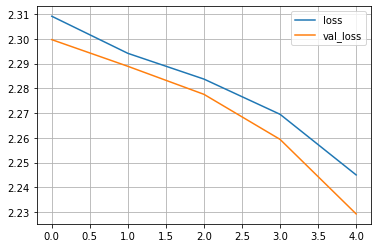

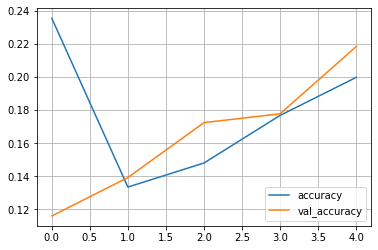

In [113]:
modelCheck.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=.0001), metrics=[metric_list])
train_logCheck = modelCheck.fit(X_train, y_train, epochs=10, batch_size=BATCH_SIZE, validation_split=.3, verbose=1, callbacks=[stopping, checkpoint])
test_evalCheck = modelCheck.evaluate(X_test, y_test, verbose=2)
plot_loss(train_logCheck)
plot_acc(train_logCheck)

### Recreating Checkpoint Model

We can now take the partially trained model that we just saved, recreate it into a new model, and continue training - or do any other model related activities that we had in mind. For this one I'll let the epochs be larger, so it can run a bit more. This training process will be a "new" one, but the starting point is where we left off with the checkpoint weights, in my trials I saw the first epoch ot have an accuracy of about 25%, the last epoch of the previous training to have an accuracy slightly under 50%, and our training here should pick up at somewhere around 50% and continue to improve.

In [114]:
modelNew = keras.Sequential()
modelNew.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"))
modelNew.add(MaxPooling2D((2, 2)))
modelNew.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"))
modelNew.add(MaxPooling2D((2, 2)))
modelNew.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"))
modelNew.add(MaxPooling2D((2, 2)))

modelNew.add(Flatten())
modelNew.add(Dense(32, activation='relu'))
modelNew.add(Dense(10, activation="softmax"))

# Load Weights
#/Volumes/Storage/git_courses/semester/1222/3950/Intro_to_Machine_Learning_Student_Workbooks/logs/weights
import os
import glob

# There is a "get_latest_checkpoint" function in the keras documentation, but it doesn't work for me
# locally. That is probably a better solution, but it appears to have some bug
# There were a couple of post online about differences on mac/win/linux, but that's not certain. 
list_of_files = glob.glob("logs/weights/*.hdf5") 
latest = max(list_of_files, key=os.path.getctime)
print(latest)
modelNew.load_weights(latest)
modelNew.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=.0001), metrics=[metric_list])

logs/weights/weights-improvement-20230325-151318.hdf5


Epoch 1/15
137/137 [==============================] - ETA: 0s - loss: 2.1060 - accuracy: 0.2517 - precision: 0.6047 - recall: 5.7778e-04
Epoch 1: val_accuracy improved from 0.21827 to 0.30547, saving model to logs/weights/weights-improvement-20230325-151318.hdf5
137/137 [==============================] - 42s 295ms/step - loss: 2.1060 - accuracy: 0.2517 - precision: 0.6047 - recall: 5.7778e-04 - val_loss: 1.9656 - val_accuracy: 0.3055 - val_precision: 0.5878 - val_recall: 0.0058
Epoch 2/15
137/137 [==============================] - ETA: 0s - loss: 1.8619 - accuracy: 0.3462 - precision: 0.6658 - recall: 0.0304
Epoch 2: val_accuracy improved from 0.30547 to 0.37447, saving model to logs/weights/weights-improvement-20230325-151318.hdf5
137/137 [==============================] - 37s 271ms/step - loss: 1.8619 - accuracy: 0.3462 - precision: 0.6658 - recall: 0.0304 - val_loss: 1.7774 - val_accuracy: 0.3745 - val_precision: 0.6559 - val_recall: 0.0543
Epoch 3/15
137/137 [======================

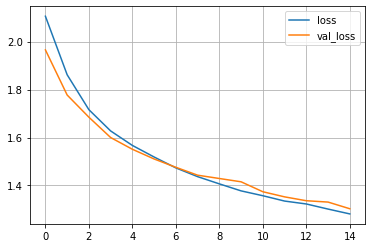

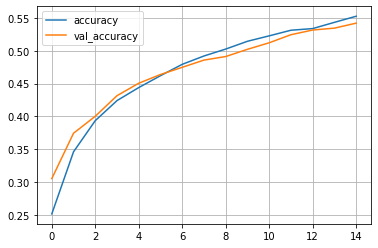

In [115]:

train_logNew = modelNew.fit(X_train, y_train, epochs=15, batch_size=BATCH_SIZE, validation_split=.3, verbose=1, callbacks=[stopping, checkpoint])
train_evalNew = modelNew.evaluate(X_train, y_train)
test_evalNew = modelNew.evaluate(X_test, y_test, verbose=2)
plot_loss(train_logNew)
plot_acc(train_logNew)

### Results and Notes

Looks pretty decent. One important factor to note is that the checkpoint only saves the weights, so the other details of the model are not carried through. In particular the optimizer is not saved, so we need to make sure we compile the model with the same optimizer that we used to train it. This will also mean that the model is not picking up exactly where it left off from in the training process, as the optimizer is also learning during the training process, and it is being reset. In general though, we should be able to pick up roughly from where we left off. 

The details vary a little depending on the exact optimizer choice, but the main thing that is "fogotten" is the learning rate and momentum of the optimizer. The optimizer will attempt to learn "how fast to move" and "how much to move" during the training process, in an effort to make the process more efficient and make convergance quicker. This information is not kept, so the new optimizer we create will start with default values that are not tailored to the model. This isn't really an issue, but the training process will likely take a bit longer than it otherwise would have. 